In [1]:
import pandas as pd
import igraph
import numpy as np
import pdb
from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2
import networkx as nx
from fa2 import ForceAtlas2

#from https://github.com/idekerlab/cy-rest-R/blob/develop/workflow1_structure_based_visualization.R

# Step 1: Network Data Preparation

Load network from NDEx

In [2]:
# nice_cx_network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='c060aff9-86d4-11e7-a10d-0ac135e8bacf')
nice_cx_network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='f1dd6cc3-0007-11e6-b550-06603eb7f303')
# nice_cx_network =  ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='ff8e7def-6e09-11e9-848d-0ac135e8bacf')

In [3]:
nice_cx_network.print_summary()

Name: CoCaNet2
Nodes: 36
Edges: 37
Node Attributes: 706
Edge Attributes: 517



In [4]:
nice_cx_from_server_df=nice_cx_network.to_pandas_dataframe()

In [5]:
nice_cx_from_server_df.head()

,source,interaction,target
0,druggable,pp,TS
1,DHFR,pp,MAPK1
2,CHEK1,pp,BLM
3,IMPDH1,pp,MTIF2
4,IMPDH1,pp,ING5


Convert it to simple edge list

In [6]:
edgelist=nice_cx_from_server_df.iloc[:,[0,2]]

Convert DF to undirected igraph object
This is a PPI network, so import as undirected.

In [7]:
tuples=[tuple(x) for x in edgelist.values]
g_original = igraph.Graph.TupleList(tuples,directed=False)

Extract componentes (individual connected subgraphs)

In [8]:
subgraphs=g_original.decompose()

Pick largest subgraph

In [9]:
tmp=[i.vcount() for i in subgraphs]
largeset_subgraph = subgraphs[tmp.index(max(tmp))]

Remove duplicate edges

In [10]:
g = largeset_subgraph.simplify(multiple=True, loops=True)
g.name = "Yeast network"

# Step 2: Basic statistical analysis

Global Network Statics

In [11]:
print("Density:",g.density())
print("Transitivity:",g.transitivity_undirected())

Density: 0.07881773399014778
Transitivity: 0.045454545454545456


Node statistics

In [12]:
g_closeness = g.vs.closeness() # Closeness Centrarity
g_degree = g.vs.degree() # Degree
g_pagerank = g.vs.pagerank(directed = False) # PageRank
g_vs_betweenness = g.vs.betweenness() # Betweenness Centrarity

Edge statics

In [13]:
g_es_betweenness = g.es.edge_betweenness() # Edge Betweenness

# Step 3: Community Detection: Try multiple algorithms

Clustering

In [14]:
communities_greedy = g.community_fastgreedy().as_clustering()
communities_leading = g.community_leading_eigenvector()
communities_label_propagation = g.community_label_propagation()

In [15]:
v_community_greedy = communities_greedy.membership
v_community_leading = communities_leading.membership
v_community_label_propagation = communities_label_propagation.membership

In [16]:
def getCommunityEdge(g, community):
    num_edges = g.ecount()
    edge_community = [-1]*num_edges
    comms = community
    sources=[i for i, _ in g.get_edgelist()]
    targets=[j for _, j in g.get_edgelist()]
    for i in range(num_edges):
        sidx = sources[i]
        tidx = targets[i]
        source = comms[sidx]
        target = comms[tidx]
        
        if source == target:
            edge_community[i] = source
    return edge_community
    

In [17]:
e_commnity_greedy = getCommunityEdge(g, v_community_greedy)
e_commnity_leading = getCommunityEdge(g, v_community_leading)
e_community_label_propagation = getCommunityEdge(g, v_community_label_propagation)

## Community to Colors

In [18]:
import seaborn as sns

In [19]:
def communityToColors(members):
    basecolor='#AAAAAA'
    num_members=len(members)
    num_communities=max(members)+1
    colors = [basecolor]*num_members
    
    colorp = sns.color_palette("hls", num_communities)
    
#     sns.palplot(colorp)
    
    #print(num_communities,num_members)
    colorpalette=[rgb2hex(int(a[0]*255),int(a[1]*255),int(a[2]*255)) for a in colorp]
    
    for i in range(num_members):
        newcolor = colorpalette[members[i]]
        if( members[i] == -1 ):
            newcolor = basecolor
        colors[i] = newcolor
    return colors

def rgb2hex(r,g,b): #RGB配列からHTMLなどに使われる16進数表現へ
    # r , g , b = 0 〜 255 # int型
    color = (r, g , b)
    html_color = '#%02X%02X%02X' % (color[0],color[1],color[2])
    return html_color


In [20]:
g.vs['color'] = communityToColors(communities_greedy.membership)
g.es['color'] = communityToColors(e_commnity_greedy)

## Convert igraph to networkx

In [21]:
def search_interaction(df,src,tgt):
    if len(df[(df['source']==src) & (df['target']==tgt)]):
        return df[(df['source']==src) & (df['target']==tgt)]['interaction'].values[0]
    else:
        return df[(df['source']==tgt) & (df['target']==src)]['interaction'].values[0]

In [22]:
G_nx=nx.Graph()
for i in range(g.vcount()):
    G_nx.add_node(g.vs['name'][i])
for i,j in g.get_edgelist():
    G_nx.add_edge(g.vs['name'][i],g.vs['name'][j])

# py2cytoscape basic setup
## Setting up py2cytoscape client

Many of the Legacy APIs are deprecated.  Check this document as the reference:

https://py2cytoscape.readthedocs.io/en/latest/

### For native version users (running from host)
You don't have to specify IP since you are running both Jupyter and Cytoscape form the same host

### For Docker users
You shoulod check the IP address of your host system (i.e., workstation's IP) and pass it to the client.

In [23]:
from py2cytoscape import cyrest

# This should be changed to your host IP
host_ip = '192.168.1.47'
cytoscape=cyrest.cyclient(host=host_ip)
cytoscape.version()
cytoscape.status()

apiVersion v1
cytoscapeVersion 3.7.1
CyREST online!


In [24]:
# Delete current session and start a new one
cytoscape.session.new()

## Layout using by ForceAtlas2

 18%|█▊        | 350/2000 [00:00<00:00, 3493.48it/s]

BarnesHut Approximation  took  0.12  seconds
Repulsion forces  took  0.16  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


100%|██████████| 2000/2000 [00:00<00:00, 4031.69it/s]
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.13  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


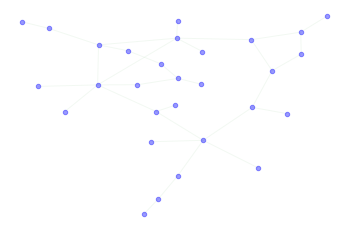

In [25]:
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

# G = nx.random_geometric_graph(400, 0.2)

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=20,
                        strongGravityMode=False,
                        gravity=10,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_igraph_layout(g, pos=None, iterations=2000)
positions_x = forceatlas2.forceatlas2_networkx_layout(G_nx, pos=None, iterations=2000)

nx.draw_networkx_nodes(G_nx, positions_x, node_size=20, with_labels=False, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G_nx, positions_x, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()


### Convert "positions" to "certesian"

In [26]:


# positions = list(positions)

# certesian = [{'node':i,'x': float(positions[n][0]),'y': float(positions[n][1])}for i, n in enumerate(positions)]
certesian = [{'node':i,'x': list(positions)[i][0],'y': list(positions)[i][1]}for i in range(len(positions))]

In [27]:
ncx_from_x=ndex2.create_nice_cx_from_networkx(G_nx)

for i in range(g.vcount()):
    ncx_from_x.set_node_attribute(i, "closeness", g_closeness[i])
    ncx_from_x.set_node_attribute(i, "degree", g_degree[i])
    ncx_from_x.set_node_attribute(i, "pagerank", g_pagerank[i])
    ncx_from_x.set_node_attribute(i, "betweenness", g_vs_betweenness[i])
    ncx_from_x.set_node_attribute(i, "community.greedy", v_community_greedy[i])
    ncx_from_x.set_node_attribute(i, "community.leading", v_community_leading[i])
    ncx_from_x.set_node_attribute(i, "community.label.propagation", v_community_label_propagation[i])
    ncx_from_x.set_node_attribute(i, "colors.community.greedy", communityToColors(v_community_greedy)[i])
    ncx_from_x.set_node_attribute(i, "colors.community.leading", communityToColors(v_community_leading)[i])
    ncx_from_x.set_node_attribute(i, "colors.community.label.propagation", communityToColors(v_community_label_propagation)[i])
 


for i in range(g.ecount()):
    ncx_from_x.set_edge_attribute(i, "betweenness.edge", g_es_betweenness[i])
    ncx_from_x.set_edge_attribute(i, "community.greedy", e_commnity_greedy[i])
    ncx_from_x.set_edge_attribute(i, "community.leading", e_commnity_leading[i])
    ncx_from_x.set_edge_attribute(i, "community.label.propagation", e_community_label_propagation[i])
    ncx_from_x.set_edge_attribute(i, "colors.community.greedy", communityToColors(e_commnity_greedy)[i])
    ncx_from_x.set_edge_attribute(i, "colors.community.leading", communityToColors(e_commnity_leading)[i])
    ncx_from_x.set_edge_attribute(i, "colors.community.label.propagation", communityToColors(e_community_label_propagation)[i])
    


In [28]:
import json

with open('tmp.json') as f:
    tmp = json.load(f)

### Apply "certesian" to NiceCX

In [29]:
print(type(ncx_from_x.VISUAL_PROPERTIES))
# ncx_from_x.set_opaque_aspect("VISUAL_PROPERTIES",colors)

# ncx_from_x.apply_template('public.ndexbio.org','92084251-c859-11e9-aa81-0ac135e8bacf')

ncx_from_x.set_opaque_aspect("cartesianLayout", certesian)
ncx_from_x.set_opaque_aspect("cyVisualProperties",tmp['cyVisualProperties'])

<class 'str'>


## Send to Cytoscape

In [30]:
import requests

cxobj = ncx_from_x.to_cx()
cyrest_url = 'http://' + host_ip + ':1234/cyndex2/v1/networks/cx'
print(cyrest_url)
response = requests.post(cyrest_url, data=json.dumps(cxobj))
print(response.json())

Generating CX
http://192.168.1.47:1234/cyndex2/v1/networks/cx
{'data': {'suid': 272524, 'uuid': ''}, 'errors': []}


##  upload the network

In [31]:
my_account="am"
my_password="ndexpassword"
my_server="http://public.ndexbio.org"

if my_account == 'enter your username here':
    print('*******WARNING!!!!*******')
    print('Please change the username and password before proceeding')
else:
    try:
        my_ndex=nc.Ndex2(my_server, my_account, my_password)
        my_ndex.update_status()
        print("Success.  Please continue.")
    except Exception as inst:
        print("Could not access account %s with password %s" % (my_account, my_password))
        print(inst.args)

Success.  Please continue.


In [32]:
upload_message=ncx_from_x.upload_to(my_server, my_account, my_password)
print(upload_message)

Generating CX
http://public.ndexbio.org/v2/network/e44e673b-c92f-11e9-aa81-0ac135e8bacf
